In [6]:
import spacy
from spacy.tokens import DocBin
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from datasets import load_dataset

### Testing data

In [2]:

# Load spaCy's language model if necessary (for example, the English model)
nlp = spacy.blank("en")  # Replace "en" with the appropriate language code

# Load your .spacy file
train_doc_bin = DocBin().from_disk("Data/train.spacy")
dev_doc_bin = DocBin().from_disk("Data/dev.spacy")
# Deserialize the docs
train_docs = list(train_doc_bin.get_docs(nlp.vocab))
dev_docs = list(dev_doc_bin.get_docs(nlp.vocab))

In [3]:
# Now you can work with the docs
for doc in train_docs[2:3]:
    for ent in doc.ents:
        print(ent.text, ent.label_)

Vijay Mishra WITNESS
HDFC Bank, Noida ORG
UP GPE
HDFC Bank ORG


In [4]:
def getLabelsCounts(docs):
    labels = []
    for doc in docs:
        for ent in doc.ents:
            labels.append(ent.label_)

    # Convert the list of labels to a NumPy array
    labels_array = np.array(labels)
    unique_labels, counts = np.unique(labels_array, return_counts=True)
    counts = dict(zip(unique_labels, counts))
    return counts

In [5]:
trainLabelsCounts = getLabelsCounts(train_docs)
devLabelsCounts = getLabelsCounts(dev_docs)

In [6]:
def saveLabelsPie(LabelsCounts, name):
    plt.figure(figsize=(8, 8))
    colors = plt.cm.hsv(np.linspace(0, 1, len(LabelsCounts)))
    patches, texts, autotexts = plt.pie(LabelsCounts.values(), labels=LabelsCounts.keys(), 
            autopct='%1.1f%%', 
            colors=colors, 
            startangle=60,
            wedgeprops=dict(edgecolor='w'))
    for text in texts + autotexts:
        text.set_fontsize(9)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    plt.title(name, pad=30, fontdict = {'fontsize':20, 'fontstyle' : 'oblique'})
    plt.savefig(f"./Plots/{name}.png", bbox_inches='tight', transparent=True)
    plt.show()



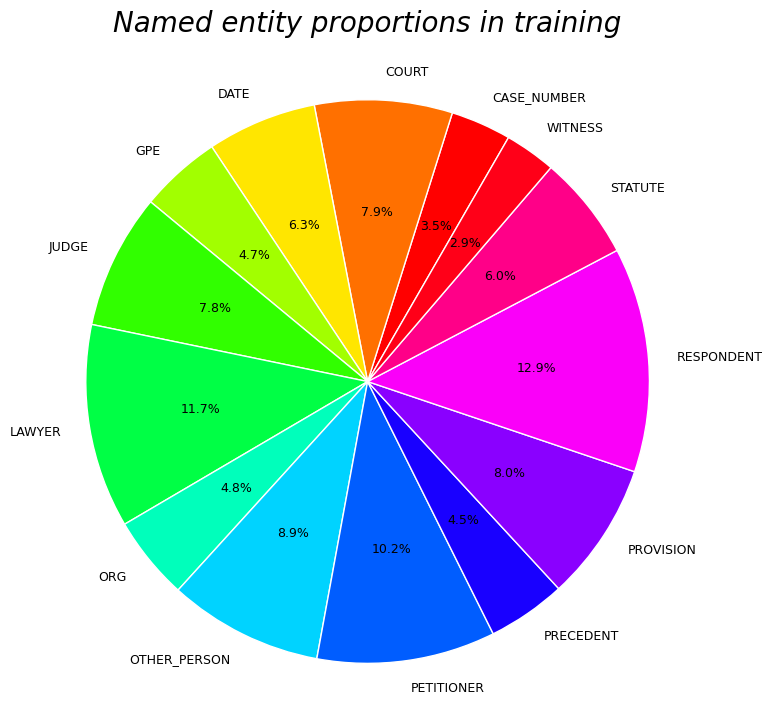

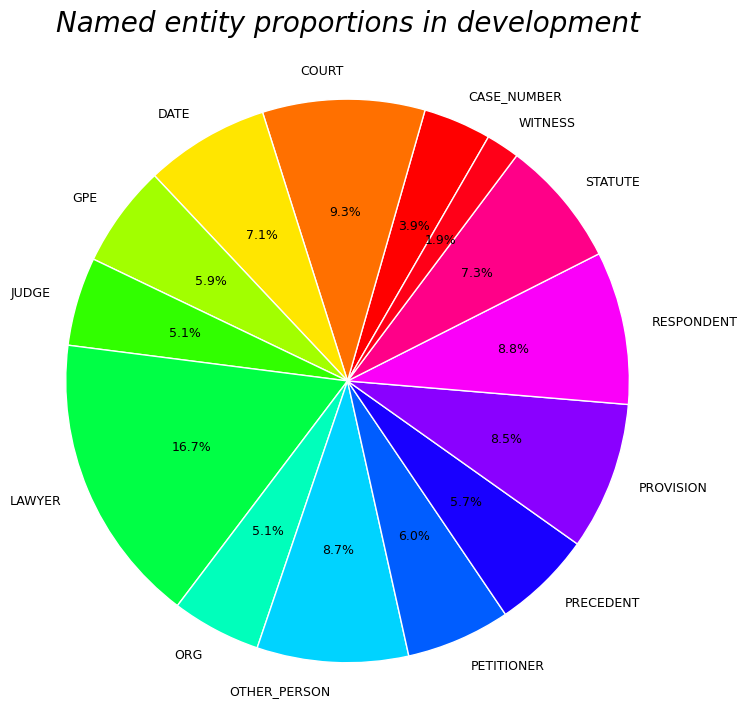

In [7]:
saveLabelsPie(trainLabelsCounts, "Named entity proportions in training")
saveLabelsPie(devLabelsCounts, "Named entity proportions in development")

### Creating train and dev csv

In [65]:
import spacy
import pandas as pd
from collections import defaultdict
import re

def format_text(text):
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Strip leading and trailing whitespace
    text = text.strip()
    return text

# Load your .spacy file
def load_spacy_file(file_path):
    nlp = spacy.blank("en")  # replace "en" with your model's language if different
    docs = DocBin().from_disk(file_path)
    return list(docs.get_docs(nlp.vocab))
    # return list(nlp.from_disk(file_path))

# Process documents and extract entities
def process_docs(docs):
    data = []
    for doc in docs:
        text = doc.text
        entities = defaultdict(set)
        for ent in doc.ents:
            entities[ent.label_].add(format_text(ent.text))
        entities = {label: list(ents) for label, ents in entities.items()}
        data.append([text, entities])
    return data

# Convert to DataFrame
def to_dataframe(data):
    # Find all unique entity labels
    all_labels = set()
    for _, entities in data:
        all_labels.update(entities.keys())
    all_labels = sorted(all_labels)

    # Create DataFrame
    df_data = []
    for text, entities in data:
        row = [format_text(text)] + [entities.get(label, []) for label in all_labels]
        df_data.append(row)

    columns = ['Sentence'] + all_labels
    return pd.DataFrame(df_data, columns=columns)

# Load data
train_docs = load_spacy_file('data/train.spacy')
dev_docs = load_spacy_file('data/dev.spacy')

# Process documents
train_data = process_docs(train_docs)
dev_data = process_docs(dev_docs)

# Convert to DataFrame
train_df = to_dataframe(train_data)
dev_df = to_dataframe(dev_data)

# Export to CSV (optional)
train_df.to_csv('./data/raw/train_data.csv', index=False)
dev_df.to_csv('./data/raw/dev_data.csv', index=False)


In [67]:
train = pd.read_csv("./data/raw/train_data.csv")
test = pd.read_csv("./data/raw/dev_data.csv")

In [68]:
dev = train.sample(frac=0.1, random_state=42) # random_state for reproducibility
train = train.drop(dev.index)

In [69]:
print(test['Sentence'].iloc[900])
print(train.iloc[900])

These are plainly disputed questions of facts and it is also apposite to examine the same in these proceedings.
Sentence        3) The National Human Rights Commission undert...
CASE_NUMBER                                                    []
COURT                                                          []
DATE                                                           []
GPE                                                            []
JUDGE                                                          []
LAWYER                                                         []
ORG                          ['National Human Rights Commission']
OTHER_PERSON                                                   []
PETITIONER                                                     []
PRECEDENT                                                      []
PROVISION                                                      []
RESPONDENT                                                     []
STATUTE                       

In [70]:
print(dev['Sentence'].iloc[-4])
print(dev.iloc[-4])

Whether ignoring the oral and the documentary evidence, the First Appellate Court decided that the suit property is not an ancestral property and that the settlement deed, Ex.B4 executed was valid?
Sentence        Whether ignoring the oral and the documentary ...
CASE_NUMBER                                                    []
COURT                                                          []
DATE                                                           []
GPE                                                            []
JUDGE                                                          []
LAWYER                                                         []
ORG                                                            []
OTHER_PERSON                                                   []
PETITIONER                                                     []
PRECEDENT                                                      []
PROVISION                                                      []
RESPONDENT

### Creating dataset that contains the prompts

In [71]:
def create_raw_entities_column(df):
    def entities_to_string(row):
        # Build a dictionary of non-empty entity categories
        entities_dict = {category: entities for category, entities in row.items() if entities!= "[]" and category != 'Sentence' and "entities" not in category }
        # Convert the dictionary to a JSON string
        return json.dumps(entities_dict, ensure_ascii=False)

    # Apply the function to each row and create the new column
    df['raw_entities'] = df.apply(entities_to_string, axis=1)
    return df

def create_dict_column(df):
    # Function to convert a JSON string to a dictionary
    def string_to_dict(json_str):
        try:
            return json.loads(json_str)
        except json.JSONDecodeError:
            return {}  # Returns an empty dictionary in case of a decoding error

    # Apply the function to the 'raw_entities' column to create a new dictionary column
    df['entities_dict'] = df['raw_entities'].apply(string_to_dict)
    return df

In [72]:
train_data = create_raw_entities_column(train)
dev_data = create_raw_entities_column(dev)
test_data = create_raw_entities_column(test)

In [73]:
train_data = create_dict_column(train_data)

dev_data = create_dict_column(dev_data)

test_data = create_dict_column(test_data)

In [74]:
dev_data['raw_entities'].iloc[-4]

'{}'

In [75]:
train_data['entities_dict'].iloc[-6]

{'COURT': "['High Court Of Madhya Pradesh ; Jabalpur']",
 'LAWYER': "['Sharda Dubey', 'Naman Nagrath', 'Himanshu Mishra']",
 'PETITIONER': "['Madhu Janiyani']",
 'RESPONDENT': "['State of M.P']"}

In [76]:
len(train_data), len(dev_data), len(test_data)

(9895, 1100, 1074)

In [77]:
def create_text_col(row):
    instruction = "You are solving the NER problem. You have to extract from the text, words related to each of the following categories: CASE_NUMBER, COURT, DATE, GPE, JUDGE, LAWYER, ORG, OTHER_PERSON, PETITIONER, PRECEDENT, PROVISION, RESPONDENT, STATUTE, WITNESS. Extract them exactly as they are in the text (Don't format them). Additionally, if a category has repeated elements in the list, they should stay as they are, don't erase the repeated. You output always should be a dictionary, if there aren't any entities in the text, just return an empty dictionary once."
    text_row = f"""<s> [INST] {instruction} Find the entities in the following text: {row['Sentence']} [/INST]\n {row['raw_entities']} </s>"""
    return text_row

In [78]:
train_data['text'] = train_data.apply(create_text_col, axis=1)
dev_data['text'] = dev_data.apply(create_text_col, axis=1)
test_data['text'] = test_data.apply(create_text_col, axis=1)

In [79]:
# train_data['train'] = train_data['raw_entities']
# dev_data['train'] = dev_data['raw_entities']
# test_data['train'] = test_data['raw_entities']

# train_data['test'] = train_data['raw_entities']
# dev_data['test'] = dev_data['raw_entities']
# test_data['test'] = test_data['raw_entities']

In [80]:
selected_columns = ['Sentence', 'raw_entities', 'text']
train_data = train_data[selected_columns]
dev_data = dev_data[selected_columns]
test_data = test_data[selected_columns]

In [81]:
test_data['text'].iloc[0]

'<s> [INST] You are solving the NER problem. You have to extract from the text, words related to each of the following categories: CASE_NUMBER, COURT, DATE, GPE, JUDGE, LAWYER, ORG, OTHER_PERSON, PETITIONER, PRECEDENT, PROVISION, RESPONDENT, STATUTE, WITNESS. Extract them exactly as they are in the text (Don\'t format them). Additionally, if a category has repeated elements in the list, they should stay as they are, don\'t erase the repeated. You output always should be a dictionary, if there aren\'t any entities in the text, just return an empty dictionary once. Find the entities in the following text: $~40 * In The High Court Of Delhi At New Delhi % Decided on: 31.07.2019 + Mac.App. 976/2018 & Cm Nos. 46122/2018, 15243/2019, 34195/2019 Oriental Insurance Co Ltd. ..... Appellant Through: Mr. S.P. Jain, Mr. Himanshu Gambhir, Mr. Nar Singh and Mr. Pushkar Singh Kanwal, Advocates. Versus Zaixhu Xie & Ors (M/S Qualcomm India Pvt Ltd ) ..... Respondents Through: Mr. Arvind Chaudhary, Advoc

In [82]:
path = "./Data/Finetuning/"

In [83]:

train_data.to_csv(path+'train.csv', index=False)
dev_data.to_csv(path+'dev.csv', index=False)
test_data.to_csv(path+'test.csv', index=False)

### Training mistral to do ner

In [ ]:
new_model = "mistral-ner" #set the name of the new model

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 25

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [ ]:
path = "./Data/Finetuning/"
data_files = {"train": path+"train.csv", "test": path+"test.csv"}
mistral_train_data = load_dataset('csv', data_files=data_files)

In [ ]:
# !pip install -q torch
# !pip install -q git+https://github.com/huggingface/transformers #huggingface transformers for downloading models weights
# !pip install -q datasets #huggingface datasets to download and manipulate datasets
# !pip install -q peft #Parameter efficient finetuning - for qLora Finetuning
# !pip install -q bitsandbytes #For Model weights quantisation
# !pip install -q trl #Transformer Reinforcement Learning - For Finetuning using Supervised Fine-tuning
# !pip install -q wandb -U #Used to monitor the model score during training

In [ ]:
import torch
from datasets import Dataset, load_dataset
from huggingface_hub import notebook_login
from peft import LoraConfig, PeftModel
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from trl import SFTTrainer

In [ ]:
# model_name = "TheBloke/Mistral-7B-Instruct-v0.1-GGUF"
# model_file = "mistral-7b-instruct-v0.1.Q4_K_M.gguf"
model_name = "mistralai/Mistral-7B-Instruct-v0.1"

# Load the base model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0}
)
# base_model = AutoModelForCausalLM.from_pretrained(model_name, model_file=model_file, model_type="mistral", device_map={"": 0})

base_model.config.use_cache = False
base_model.config.pretraining_tp = 1

# Load MitsralAi tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
# Set LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=100, # the total number of training steps to perform
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Initialize the SFTTrainer for fine-tuning
trainer = SFTTrainer(
    model=base_model,
    train_dataset=mistral_train_data['train'],
    eval_dataset=mistral_train_data['test'],
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,  # You can specify the maximum sequence length here
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

In [ ]:
trainer.train()